In [29]:
#---standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil # only applicable to moving the files
import os
#-----for working with audio files (need to conda install these)
import librosa 
import librosa.display

### Read Me

This script bypasses the need to work with a csv for the audio portions. The csv seems to corrupt the output of librosa, so this is the easiest way to preserve librosa output 

In [15]:
def undersample_data(filename):
    ## given a csv file, balances the dataset by undersampling method
    ## Split Dataset into Aves and Carnivora
    sdf = pd.read_csv(filename)
    aves = sdf[sdf['group']=='Aves']
    aves_grouped = aves.groupby(['Common Name']).size().reset_index(name='counts')
    carnivora = sdf[sdf['group']=='Carnivora']
    carn_grouped = carnivora.groupby(['Common Name']).size().reset_index(name='counts')
    #reduce datasets to only species with between 20 & 80 files
    aves_short = aves_grouped[aves_grouped['counts'].between(20,80)]
    carn_short = carn_grouped[carn_grouped['counts'].between(20,80)]
    ##randomly sample species list, to get a subset of aves, so the length is closer to len(carn)
    aves_short_sampled = aves_short.sample(16)
    aves_short_sampled.groupby(['Common Name']).size().reset_index(name='counts')
    #create the final sampled aves and carn lists from original split lists 
    aves_df = aves[aves['Common Name'].isin(aves_short_sampled['Common Name'])]
    carn_df = carnivora[carnivora['Common Name'].isin(carn_short['Common Name'])]
    #combine the split lists back into one list 
    undersampled_df = pd.concat([aves_df,carn_df])
    return undersampled_df

## These were used to pull only the relevant wav files for our ML portion, only works will full set of wav files

In [16]:
#lst = undersample_data('spectrogram2.csv')
#display(len(lst['gbifID']))
#id_array = lst['gbifID'].to_list()

1326

In [28]:
#----saves undersampled data to csv (these entries correspond to the files in the zipped wavsubset folder)
#lst[['gbifID', 'type','format','URL','group','Common Name', 'Scientific Name', 'Type', 'id']].to_csv('undersampled_data.csv')

In [24]:
#for the sampled list, copy the relevant wav files to share so script can be run
srcdir = '/Users/katel/Documents/output/output/wavs'
dstdir = '/Users/katel/Documents/output/output/wavsubset'
def copy_relevant_wav_files(srcdir, dstdir):
    #used to get the relevant wav files for the next section 
    for filename in os.scandir(srcdir):
        if not filename.is_file():
            continue

        gid = os.path.basename(filename.path.split(".")[0])
        if int(gid) not in id_array:
            continue

        src = filename.path
        dst =  f'{dstdir}/{gid}.wav'

        shutil.copyfile(src, dst)

## Functions Used

Below is several functions used to create spectrograms, there is a function at the end ('create_spectro_df') that should be all you need to create a pandas df containing spectrograms directly from the wav files. 

In [58]:
#------use to output mfcc
def convert_wav_to_mfcc(filename):
    """
    #helper function called in output_mfcc
    #loads and decodes audio as time series
    #(y = 1d np array, sr = sampling rate, #samples per second of audio)
    #default resample = 22050 Hz, changed to 44100
    """
    y, sr = librosa.load(filename, sr=44100)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    zero_crossings_count = librosa.zero_crossings(y, pad=False)
    zero_crossings = sum(zero_crossings_count)
    return mfcc, y, sr, zero_crossings

def output_mfcc(directory):
    #---takes directory of wav files to convert
    #---Stores MFCC outputs in lists 
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst = []
    mfcc_lst = []
    zero_crossings_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 200 == 0:
            print(i, end=",")
        if filename.is_file():
            mfcc, y, sr, zero_crossings = convert_wav_to_mfcc(filename.path)
            gid = os.path.basename(filename.path.split(".")[0])
            good_id_lst.append(gid)
            y_lst.append(y)
            sr_lst.append(sr)
            mfcc_lst.append(mfcc)
            zero_crossings_lst.append(zero_crossings)
    return good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst

In [59]:
#---use to output melspectrogram in decibels
def convert_wav_to_melspectro(filename):
    #helper function called in output_melspectro
    y, sr = librosa.load(filename, sr=44100)
    melspectro = librosa.feature.melspectrogram(y=y, sr=sr)
    melspectro_db = librosa.power_to_db(melspectro, ref=np.max)
    zero_crossings_count = librosa.zero_crossings(y, pad=False)
    zero_crossings = sum(zero_crossings_count)
    return melspectro_db, y, sr, zero_crossings

def output_melspectro(directory):
    #---takes directory of wav files to convert
    #---Stores melspectro outputs in lists 
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst = []
    melspectro_lst = []
    zero_crossings_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 200 == 0:
            print(i, end=",")
        if filename.is_file():
            melspectro_db, y, sr, zero_crossings = convert_wav_to_melspectro(filename.path)
            gid = os.path.basename(filename.path.split(".")[0])
            good_id_lst.append(gid)
            y_lst.append(y)
            sr_lst.append(sr)
            melspectro_lst.append(melspectro_db)
            zero_crossings_lst.append(zero_crossings)
    return good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst

In [66]:
#---use to turn mfcc or melspectro data into dataframe
def convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, spectrogram_lst, zero_crossings_lst):
    #takes outputs of output_melspectro or output_mfcc functions AND undersampled_data, returns dataframe
    #where spectrogram_lst = mfcc or melspectro list 
    final_id_lst = []
    for i in good_id_lst:
        fin = i.split(".")[0]
        final_id_lst.append(fin)
            
    spectro_dic = {'id':final_id_lst,'y':y_lst,'sr': sr_lst,'spectrogram': spectrogram_lst, 'zero_crossing':zero_crossings_lst}
    spectro_df = pd.DataFrame(spectro_dic)

    spectro_df['gbifID'] = spectro_df['id'].astype('int64')
    spectrogram_df = pd.merge(undersampled_df, spectro_df, on='gbifID', how="left")
    return spectrogram_df

In [37]:
def test_librosa(filepath):
    ##--test sample audio file to test librosa output 
    y, sr = librosa.load(filepath, sr=44100)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    print("Total MFCC features " + str(mfcc.shape[0]) + " for the total " + str(mfcc.shape[1]) + " frames." )
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')

In [63]:
def draw_spectrogram(spectrogram, sr):
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time')

## Review Undersampled Data

Data is now close to balanced, there are approximately equal number of species and anywhere from 20-80 samples per species in each group

In [56]:
undersampled_df = pd.read_csv('undersampled_data.csv')
names = undersampled_df.groupby(['group','Type','Common Name']).size().reset_index(name='counts')
display(names)

,group,Type,Common Name,counts
0,Aves,Not Dangerous,Athene,20
1,Aves,Not Dangerous,Crested Lark,23
2,Aves,Not Dangerous,European Nightjar,34
3,Aves,Not Dangerous,Fieldfare,35
4,Aves,Not Dangerous,Firecrest,23
5,Aves,Not Dangerous,Grasshopper Warbler,38
6,Aves,Not Dangerous,Grey-Heades Woodpecker,42
7,Aves,Not Dangerous,Hill Myna,61
8,Aves,Not Dangerous,Mallard,45
9,Aves,Not Dangerous,Mistle Thrush,42


## Start Here!!

In [93]:
def create_spectro_df(directory, desired_type, undersampled_df):
    """
    directory = supply directory of .wav files from wavsubset.zip 
       Ex: directory  = '/Users/katel/Documents/output/output/wavsubset'
    desired_type = 'mfcc' or 'melspectro'
    undersampled_df = pd.read_csv('undersampled_data.csv') - above
    """
    if desired_type == 'mfcc':
        good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst = output_mfcc(directory)
        mfcc_df = convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst)
        return mfcc_df
    elif desired_type == 'melspectro':
        good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst = output_melspectro(directory)
        melspectro_df = convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst)
        return melspectro_df
    else: 
        print("error, make sure you supplied correct input")
        
    

### Ensure you change directory of the next two cells to wherever 'wavsubset.zip' is stored (in unzipped form)

In [85]:
%%time
#---change directory to wherever you stored the 'wavsubset.zip' files 
mfcc_df = create_spectro_df(directory  = '/Users/katel/Documents/output/output/wavsubset', desired_type='mfcc', undersampled_df = undersampled_df)

200,400,600,800,1000,1200,Wall time: 12min 17s


In [94]:
%%time
#---change directory to wherever you stored the 'wavsubset.zip' files 
melspectro_df = create_spectro_df(directory  = '/Users/katel/Documents/output/output/wavsubset', desired_type='melspectro', undersampled_df = undersampled_df)

200,400,600,800,1000,1200,Wall time: 12min 5s


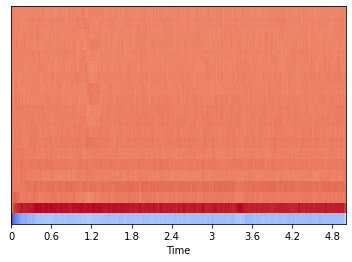

In [86]:
#test on one output for mfcc df
draw_spectrogram(mfcc_df['spectrogram'][0], mfcc_df['sr'][0])

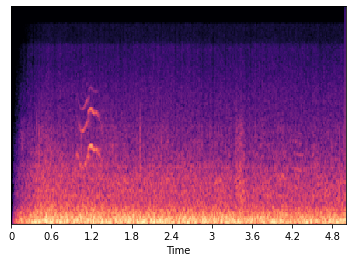

In [95]:
# test on one output for melspectro df
draw_spectrogram(melspectro_df['spectrogram'][0], melspectro_df['sr'][0])

In [87]:
display(mfcc_df.head())

,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-801.48914, -800.42334, -772.44196, -732.381...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-595.9011, -593.62805, -566.94946, -539.8847...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,Not Dangerous,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-722.07367, -719.8397, -672.3625, -615.5229,...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,Not Dangerous,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-673.0887, -632.0292, -465.77396, -348.41882...",48782
4,332,1269848114,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cor...,Aves,Raven,Corvus corax,Not Dangerous,1269848114,1269848114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-669.52844, -669.0911, -610.478, -492.42038,...",29243


In [96]:
display(melspectro_df.head())

,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -80.0, -50.316353, -45.723316, -42.37...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -76.81369, -58.618816, -47.21679, -40...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,Not Dangerous,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -70.03779, -45.730125, -38.054024, -3...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,Not Dangerous,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -59.98756, -39.351402, -28.339111, -2...",48782
4,332,1269848114,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cor...,Aves,Raven,Corvus corax,Not Dangerous,1269848114,1269848114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -77.60765, -51.018013, -43.877937, -4...",29243
